# Определение возраста покупателей

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Первичное-изучение-данных" data-toc-modified-id="Первичное-изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Первичное изучение данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Исследовательский анализ данных

# Исследовательский анализ данных

**Цель** - обучить модель, которая сможет оценивать возраст посетителей супермаркета по внешности, чтобы предлагать потенциально интересные товары и контролировать соблюдение кассирами запрета на продажу алкоголя несовершеннолетним.

Для решения задачи компьютерного зрения нам лучше всего подойдут нейросети: изображения содержат слишком большое количество признаков, чтобы пытаться работать с ними при помощи классических алгоритмов.

## Первичное изучение данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

У нас есть датафрейм, в котором содержится информация о фотографиях и возрасте людей, на них изображённых.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Выведем датафрейм, чтобы лучше представлять структуру данных и понимать, как настраивать наш загрузчик данных.

In [3]:

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Понятно: первый столбец отвечает за имя файла, а второй - за целевой признак.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- Как видим, в датасете 7591 объект.
- Пропусков нет.
- Типы данных вполне соответствуют тем признакам, которые они описывают.
Посмотрим на то, какое распределение имеет возраст.

**Отображение гистограммы с плотностью вероятностей**

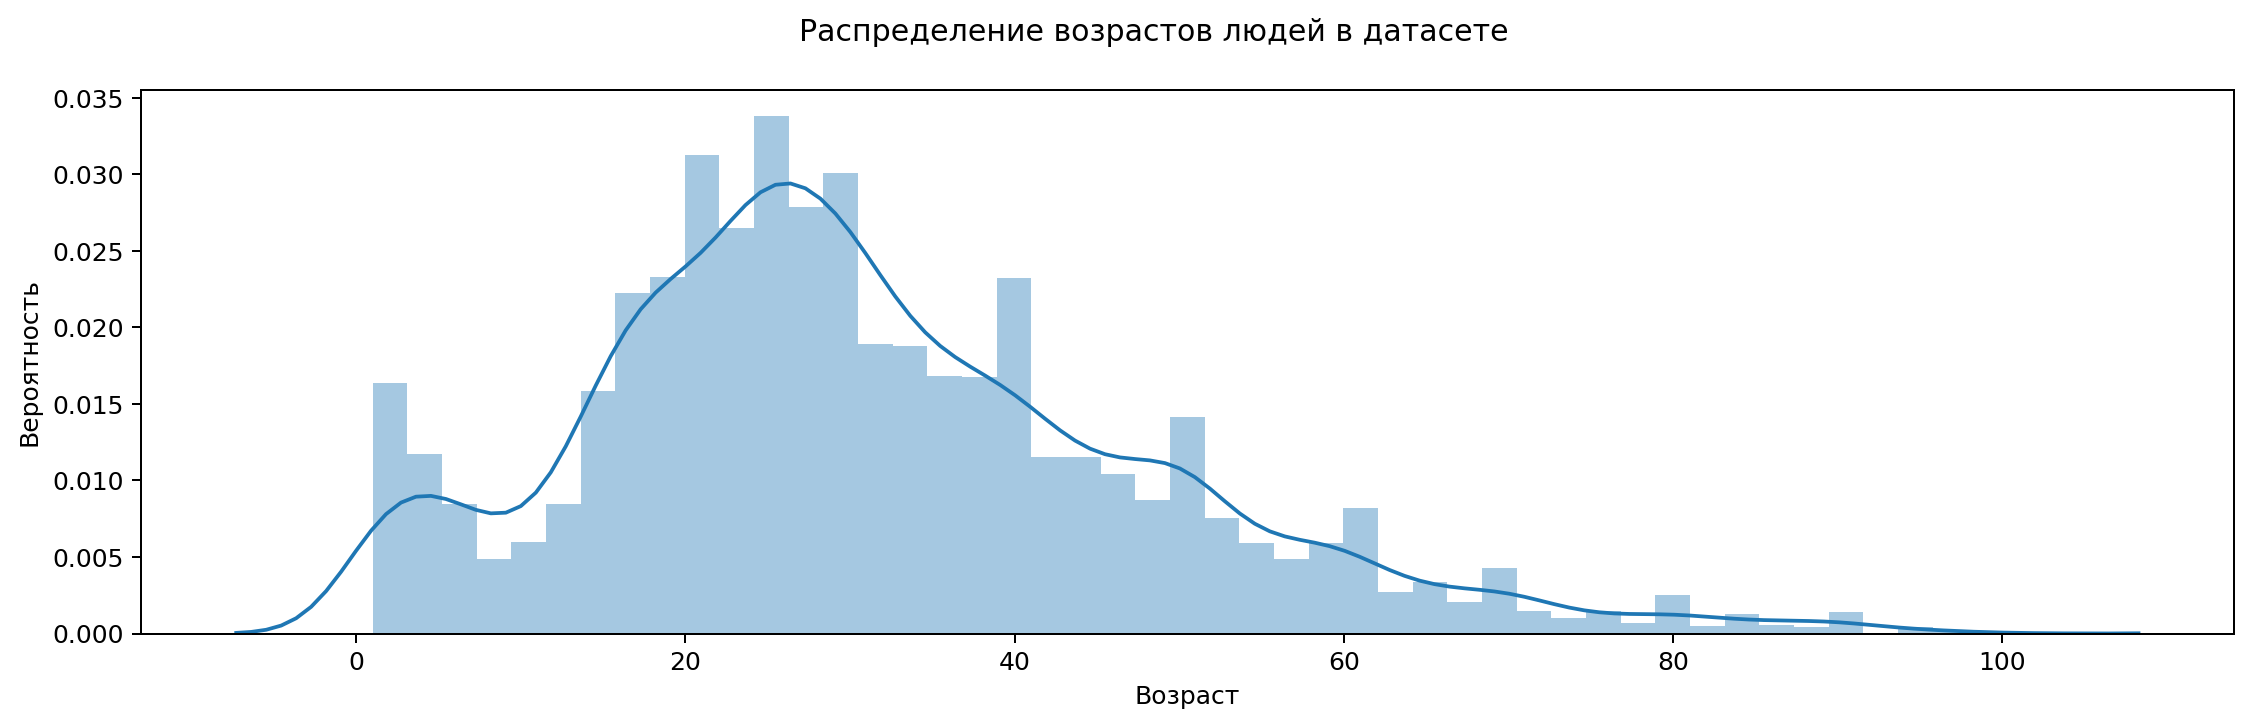

In [5]:
plt.figure(figsize=(15, 4), dpi=180)
sns.distplot(labels.real_age)
plt.xlabel('Возраст')
plt.ylabel('Вероятность')
plt.suptitle('Распределение возрастов людей в датасете')
plt.show()
plt.close()

Интересно, почему в распределении реже встречаются дети в возрасте около 9 лет. Видимо, так собран наш набор данных.

Посмотрим на фотографии из обучающей выборки. Но сперва их загрузим.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
# Возьмём из итератора один батч
images = next(train_gen_flow)

In [8]:
# Посмотрим на размер батча с изображениями
images[0].shape

(32, 224, 224, 3)

Видим 32 картинки размером 224*224 пикселя, и каждый пиксель состоит из 3 значений: красный, зелёный, синий.

Используем Matplotlib для отображения фотографий.

In [9]:
def remove_ticks():
    """Убирает оси с изображения."""
    plt.xticks([])
    plt.yticks([])

**Вывод фотографий с указанием возраста**

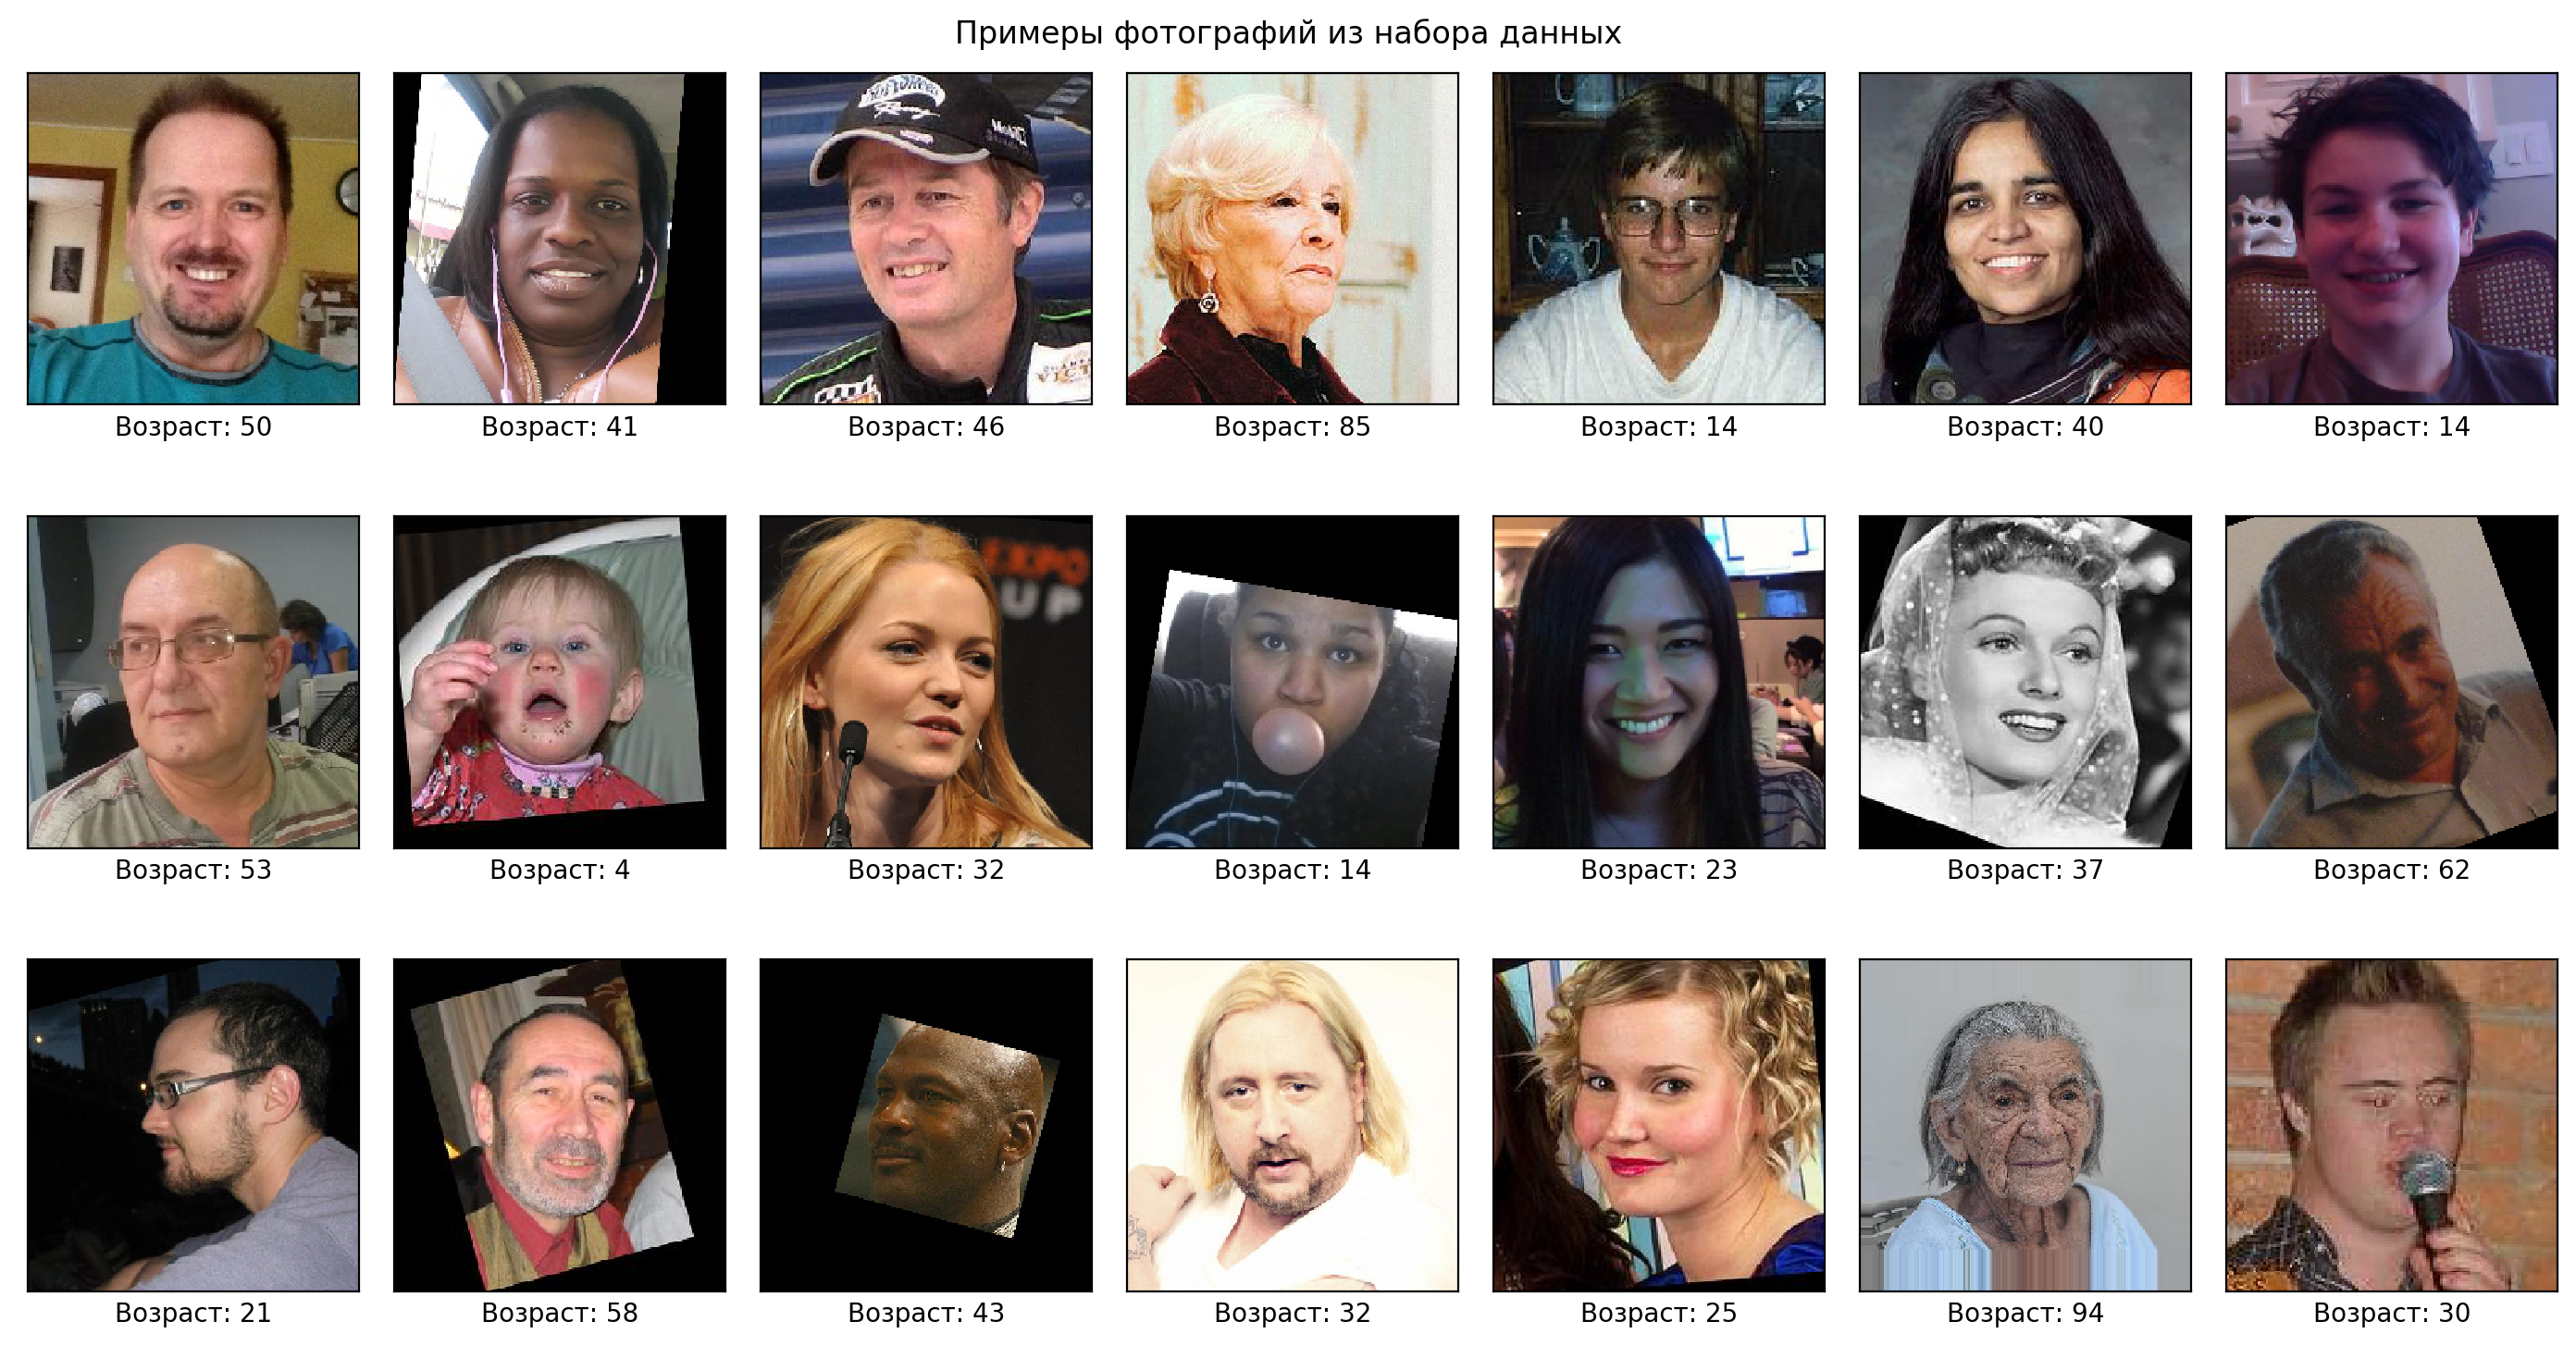

In [10]:

plt.figure(figsize=(14, 7.5), dpi=200)
for (i, img), label in zip(enumerate(images[0][:21]),
                           images[1]):
    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    remove_ticks()
    plt.xlabel(f'Возраст: {label}')
plt.suptitle('Примеры фотографий из набора данных')
plt.tight_layout(pad=1)
plt.show()
plt.close()


Как видим, фотографии самые разнообразные:

- С разными цветовыми характеристиками (даже чёрно-белые).
- С разным положением головы.


## Обучение модели

Мы не будем обучать модель здесь, а просто скопируем код, который задаёт её параметры. Сама модель будет обучена на GPU отдельно.

- В качестве модели используем архитектуру ResNet50, предобученную на базе ImageNet.
- Устанавливаем полносвязный слой с одним нейроном.
- Количество эпох -  10.
- Функции потерь - MSE.
- Мы попробовали разные значения скорости обучения и выяснили, что значение 0.0005 вполне нам подходит, поскольку при длительном обучении и большем learning rate функция потерь начинает "застревать" и колебаться между похожими значениями - а значит, ходить кругами вокруг минимума, но не попадать в него.

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 178 steps, validate for 60 steps

Epoch 1/10

178/178 - 104s - loss: 203.3670 - mae: 10.5821 - val_loss: 562.0910 - val_mae: 18.5826

Epoch 2/10

178/178 - 37s - loss: 104.1842 - mae: 7.7692 - val_loss: 382.8874 - val_mae: 16.4911

Epoch 3/10

178/178 - 36s - loss: 66.3512 - mae: 6.2314 - val_loss: 477.0592 - val_mae: 16.6228

Epoch 4/10

178/178 - 36s - loss: 46.6206 - mae: 5.1983 - val_loss: 260.1094 - val_mae: 12.2166

Epoch 5/10

178/178 - 36s - loss: 31.5311 - mae: 4.3053 - val_loss: 93.3764 - val_mae: 7.3107

Epoch 6/10

178/178 - 37s - loss: 23.3122 - mae: 3.7476 - val_loss: 82.4489 - val_mae: 6.6833

Epoch 7/10

178/178 - 37s - loss: 16.8243 - mae: 3.1590 - val_loss: 77.7029 - val_mae: 6.7056

Epoch 8/10

178/178 - 36s - loss: 14.4037 - mae: 2.9329 - val_loss: 89.9884 - val_mae: 7.2584

Epoch 9/10

178/178 - 36s - loss: 12.2843 - mae: 2.6848 - val_loss: 81.8254 - val_mae: 6.9419

Epoch 10/10

178/178 - 36s - loss: 11.3704 - mae: 2.5679 - val_loss: 75.6293 - val_mae: 6.7644

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  
60/60 - 9s - loss: 75.6293 - mae: 6.7644

Test MAE: 6.7644

В результате нам удалось достичь MAE чуть меньше 7, что весьма неплохо и достаточно по условию задачи!

## Анализ обученной модели

**Средняя ошибка модели равна 7. Что это может значить?**

- Если мы предложим модели назвать возраст ребёнка на фотографии, то она вряд ли перепутает его с пожилым человеком.
- Сложно сказать, на людях каких возрастов модель ошибается больше всего. У нас нет возможности посмотреть на предсказания в силу реализации обучения, но если бы они у нас имелись, то мы могли бы категоризовать фотографии по возрасту и найти ошибку для каждой категории.
- В работу модели могут вносить случайность сами люди с фотографий: некоторые люди выглядят значительно старше своего возраста, другие - наоборот, вечно молодые.
- Опять же, перед нами не стоит цель назвать точный возраст конкретного человека. Модель скорее оценивает фотографию по тем признакам, которые ей удалось усвоить, и говорит, что "человек с такой-то внешностью тянет на такой-то возраст". Возможно, что в этом смысле модель ведёт себя подобно людям и ошибается в тех же местах, где ошибся бы человек.

**Будет ли от модели польза для бизнеса?**

- Если мы имеем ошибку в 7 лет, то рискуем не отличить взрослого от ребёнка в случае с продажей алкоголя. Паспорт всё так же придётся спрашивать.
- С рекомендацией товаров всё лучше: потребности людей не меняются кардинально раз в год, и у нас будет возможность довольно точно определять крупные возрастные категории - детей, подростков, молодых, зрелых, пенсионеров и изучать их потребности в автоматическом режиме. Допустим, если у нас есть предсказанный возраст человека и его чек, то мы можем совместить данные о транзакции с возрастом и сделать предположение о том, что тот или иной товар интересен аудитории.